In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')
import string
import nltk
from nltk.corpus import  stopwords
nltk.download('stopwords')
import os
get_ipython().system('pip install wordcloud')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_train=pd.read_csv('train_malignant.csv',encoding='latin-1')
df_test=pd.read_csv('test_malignant.csv',encoding='latin-1')
df_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
print('train data shape:',df_train.shape)
print('test data shape:',df_test.shape)

train data shape: (159571, 8)
test data shape: (153164, 2)


# as we can see there are two datasets which are given having the shape respectively. our goal is to identify the coloumns which are offensive or non-offensive in nature and build a model accordingly to minimixe the cyberbullying.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
df_train.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

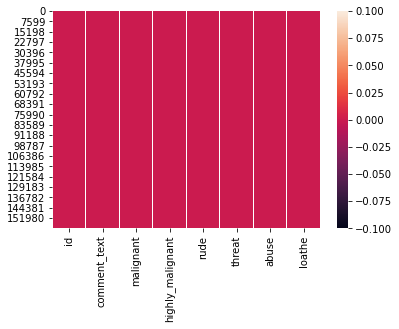

In [7]:
sns.heatmap(df_train.isnull())

there is no null value present in our train dataset.

In [8]:
print ('0 and 1 counts','\n',df_train.malignant.value_counts(),'\n',df_train.highly_malignant.value_counts(),'\n',df_train.rude.value_counts(),'\n',df_train.threat.value_counts(),'\n',df_train.abuse.value_counts(),'\n',df_train.loathe.value_counts())


0 and 1 counts 
 0    144277
1     15294
Name: malignant, dtype: int64 
 0    157976
1      1595
Name: highly_malignant, dtype: int64 
 0    151122
1      8449
Name: rude, dtype: int64 
 0    159093
1       478
Name: threat, dtype: int64 
 0    151694
1      7877
Name: abuse, dtype: int64 
 0    158166
1      1405
Name: loathe, dtype: int64


In [9]:
df_train['length_comment'] = df_train.comment_text.str.len()
df_train.head(5)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,length_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67


In [10]:
df_train['comment_text'] = df_train['comment_text'].str.lower()

In [11]:
# Replace email addresses with 'email'
df_train['comment_text'] = df_train['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
df_train['comment_text'] = df_train['comment_text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df_train['comment_text'] = df_train['comment_text'].str.replace(r'£|\$', 'dollers')

# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df_train['comment_text'] = df_train['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')
# Replace numbers with 'numbr'
df_train['comment_text'] = df_train['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [12]:
# Remove punctuation
df_train['comment_text'] = df_train['comment_text'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df_train['comment_text'] = df_train['comment_text'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df_train['comment_text'] = df_train['comment_text'].str.replace(r'^\s+|\s+?$', '')

In [13]:
df_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,length_comment
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0,112
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0,233
3,0001b41b1c6bb37e,more i can t make any real suggestions on impr...,0,0,0,0,0,0,622
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,67


In [14]:
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df_train['comment_text'] = df_train['comment_text'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [15]:
df_train['clean_length_of_comment_text'] = df_train.comment_text.str.len()
df_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,length_comment,clean_length_of_comment_text
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,264,170
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0,112,93
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,233,141
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0,622,374
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,67,29


In [16]:
print ('Original Length of comment_text:', df_train.length_comment.sum())
print ('Clean Length of comment_text:', df_train.clean_length_of_comment_text.sum())

Original Length of comment_text: 62995074
Clean Length of comment_text: 40636416


# maliganant comments as per unclean and clean lenght of comments

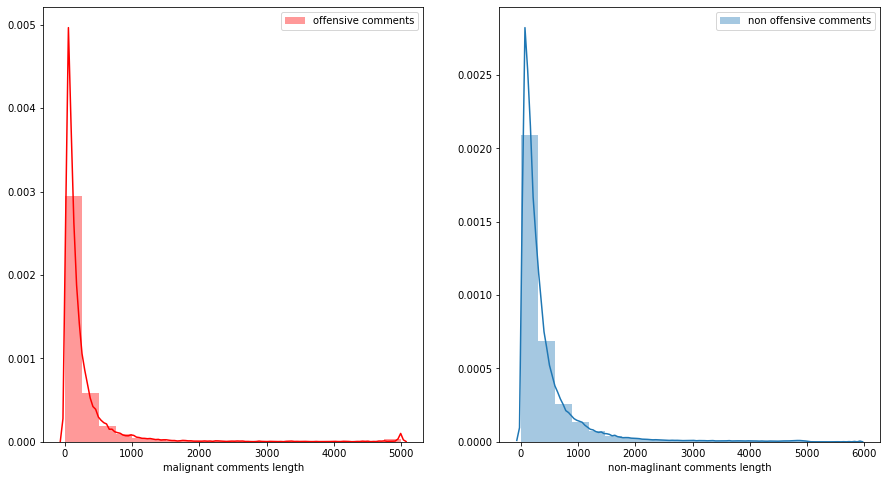

In [17]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['malignant']==1]['length_comment'],bins=20,ax=ax[0],label='offensive comments',color='r')

ax[0].set_xlabel('malignant comments length')
ax[0].legend()

sns.distplot(df_train[df_train['malignant']==0]['length_comment'],bins=20,ax=ax[1],label='non offensive comments')
ax[1].set_xlabel('non-maglinant comments length')
ax[1].legend()

plt.show()

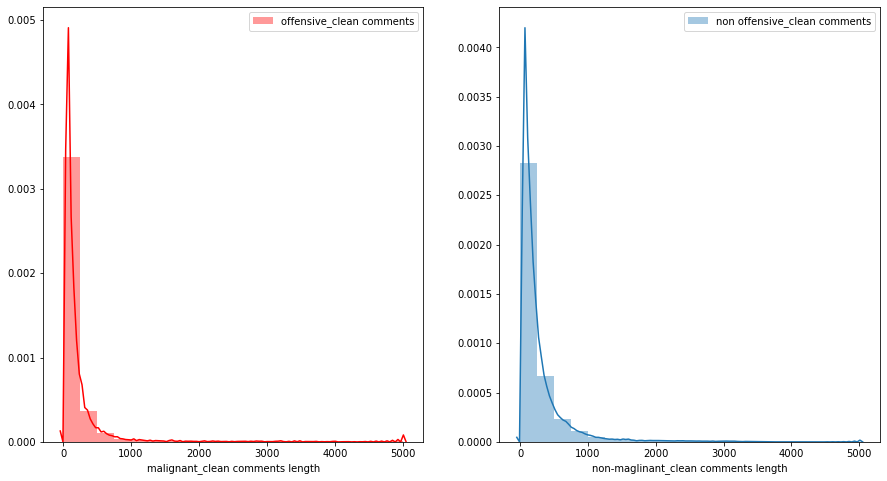

In [18]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['malignant']==1]['clean_length_of_comment_text'],bins=20,ax=ax[0],label='offensive_clean comments',color='r')

ax[0].set_xlabel('malignant_clean comments length')
ax[0].legend()

sns.distplot(df_train[df_train['malignant']==0]['clean_length_of_comment_text'],bins=20,ax=ax[1],label='non offensive_clean comments')
ax[1].set_xlabel('non-maglinant_clean comments length')
ax[1].legend()

plt.show()

# highly-maglinant comments as per unclean and clean lenght of comments

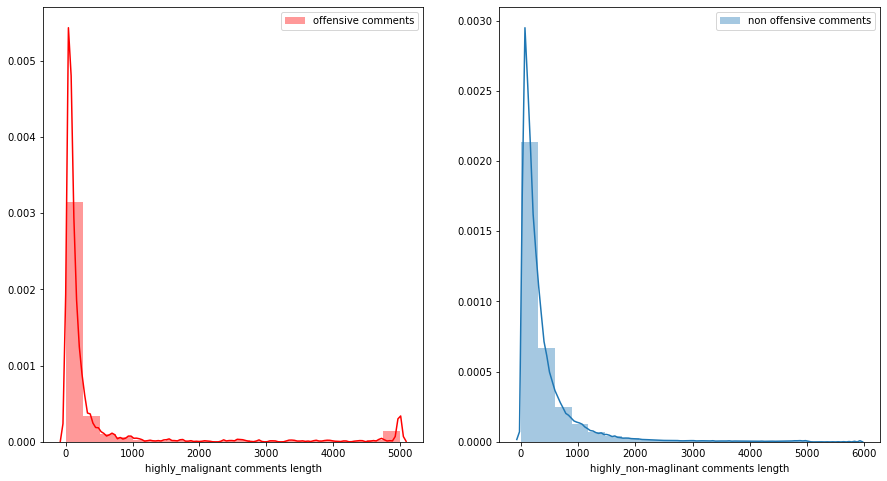

In [19]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['highly_malignant']==1]['length_comment'],bins=20,ax=ax[0],label='offensive comments',color='r')

ax[0].set_xlabel('highly_malignant comments length')
ax[0].legend()

sns.distplot(df_train[df_train['highly_malignant']==0]['length_comment'],bins=20,ax=ax[1],label='non offensive comments')
ax[1].set_xlabel('highly_non-maglinant comments length')
ax[1].legend()

plt.show()

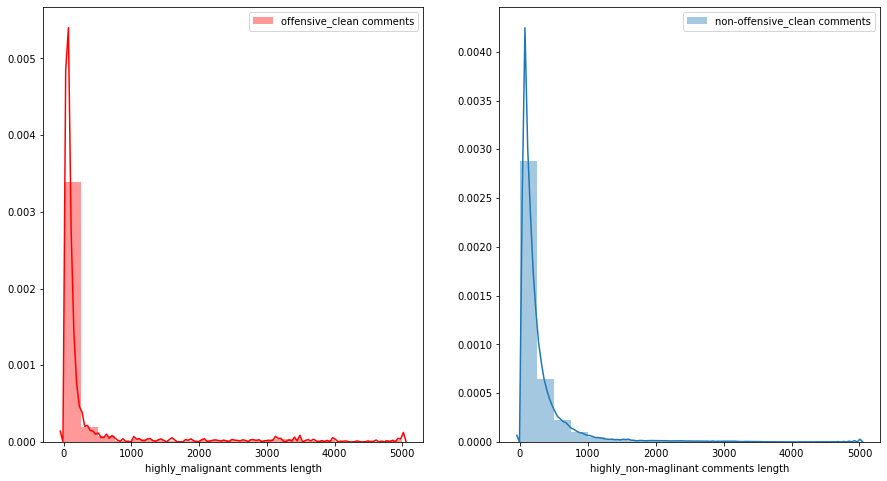

In [20]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['highly_malignant']==1]['clean_length_of_comment_text'],bins=20,ax=ax[0],label='offensive_clean comments',color='r')

ax[0].set_xlabel('highly_malignant comments length')
ax[0].legend()

sns.distplot(df_train[df_train['highly_malignant']==0]['clean_length_of_comment_text'],bins=20,ax=ax[1],label='non-offensive_clean comments')
ax[1].set_xlabel('highly_non-maglinant comments length')
ax[1].legend()

plt.show()

# rude comments as per unclean and clean lenght of comments

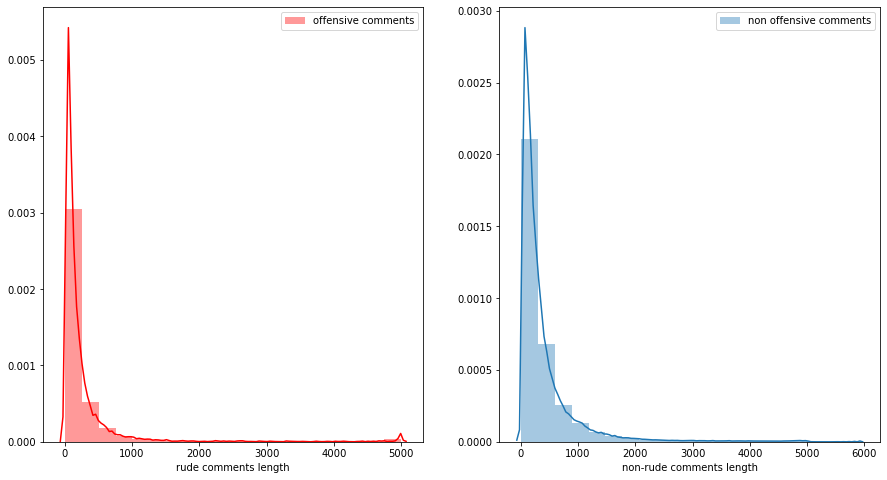

In [21]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['rude']==1]['length_comment'],bins=20,ax=ax[0],label='offensive comments',color='r')

ax[0].set_xlabel('rude comments length')
ax[0].legend()

sns.distplot(df_train[df_train['rude']==0]['length_comment'],bins=20,ax=ax[1],label='non offensive comments')
ax[1].set_xlabel('non-rude comments length')
ax[1].legend()

plt.show()

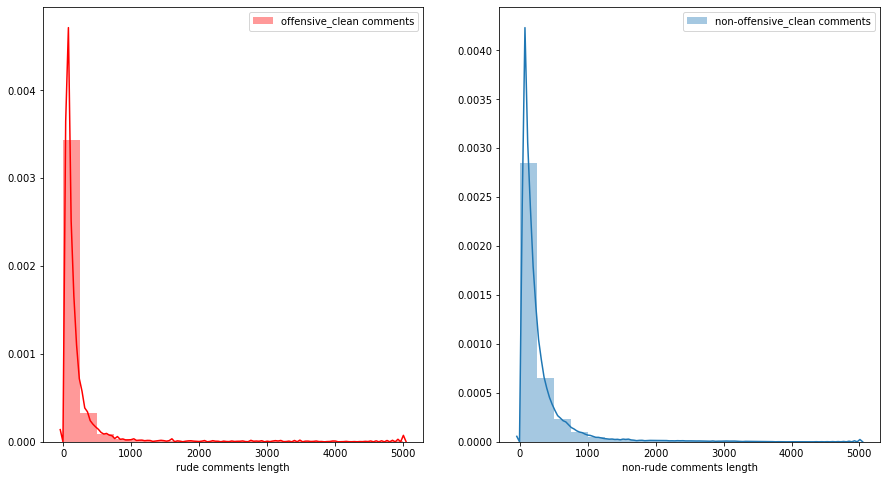

In [22]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['rude']==1]['clean_length_of_comment_text'],bins=20,ax=ax[0],label='offensive_clean comments',color='r')

ax[0].set_xlabel('rude comments length')
ax[0].legend()

sns.distplot(df_train[df_train['rude']==0]['clean_length_of_comment_text'],bins=20,ax=ax[1],label='non-offensive_clean comments')
ax[1].set_xlabel('non-rude comments length')
ax[1].legend()

plt.show()

# threat comments as per unclean and clean lenght of comments

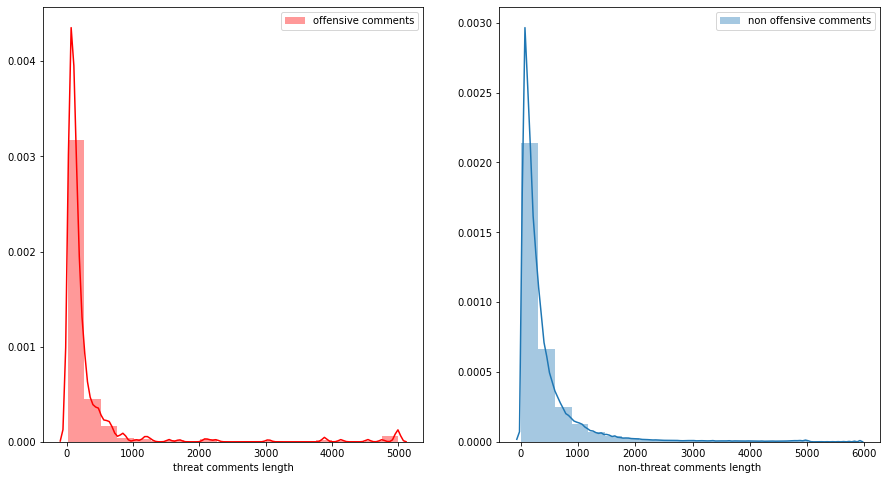

In [23]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['threat']==1]['length_comment'],bins=20,ax=ax[0],label='offensive comments',color='r')

ax[0].set_xlabel('threat comments length')
ax[0].legend()

sns.distplot(df_train[df_train['threat']==0]['length_comment'],bins=20,ax=ax[1],label='non offensive comments')
ax[1].set_xlabel('non-threat comments length')
ax[1].legend()

plt.show()

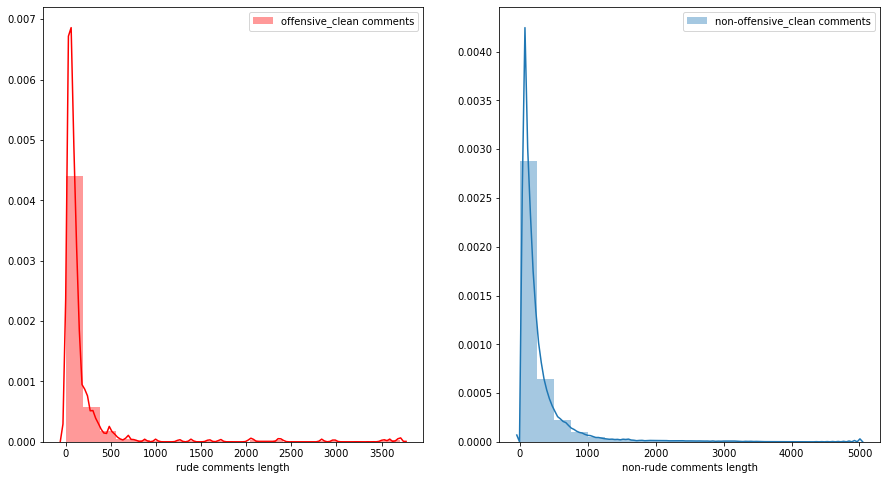

In [24]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['threat']==1]['clean_length_of_comment_text'],bins=20,ax=ax[0],label='offensive_clean comments',color='r')

ax[0].set_xlabel('rude comments length')
ax[0].legend()

sns.distplot(df_train[df_train['threat']==0]['clean_length_of_comment_text'],bins=20,ax=ax[1],label='non-offensive_clean comments')
ax[1].set_xlabel('non-rude comments length')
ax[1].legend()

plt.show()

# abuse comments as per unclean and clean lenght of comments

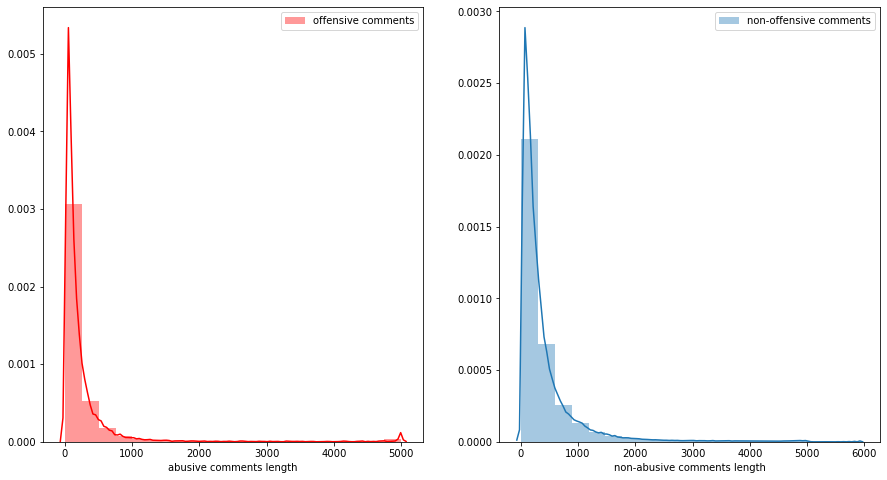

In [25]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['abuse']==1]['length_comment'],bins=20,ax=ax[0],label='offensive comments',color='r')

ax[0].set_xlabel('abusive comments length')
ax[0].legend()

sns.distplot(df_train[df_train['abuse']==0]['length_comment'],bins=20,ax=ax[1],label='non-offensive comments')
ax[1].set_xlabel('non-abusive comments length')
ax[1].legend()

plt.show()

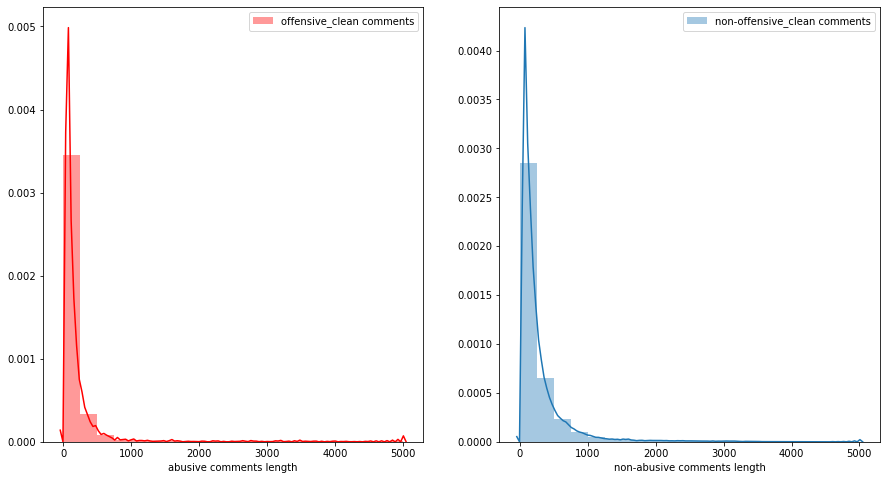

In [26]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['abuse']==1]['clean_length_of_comment_text'],bins=20,ax=ax[0],label='offensive_clean comments',color='r')

ax[0].set_xlabel('abusive comments length')
ax[0].legend()

sns.distplot(df_train[df_train['abuse']==0]['clean_length_of_comment_text'],bins=20,ax=ax[1],label='non-offensive_clean comments')
ax[1].set_xlabel('non-abusive comments length')
ax[1].legend()

plt.show()

# loathe comments as per unclean and clean lenght of comments

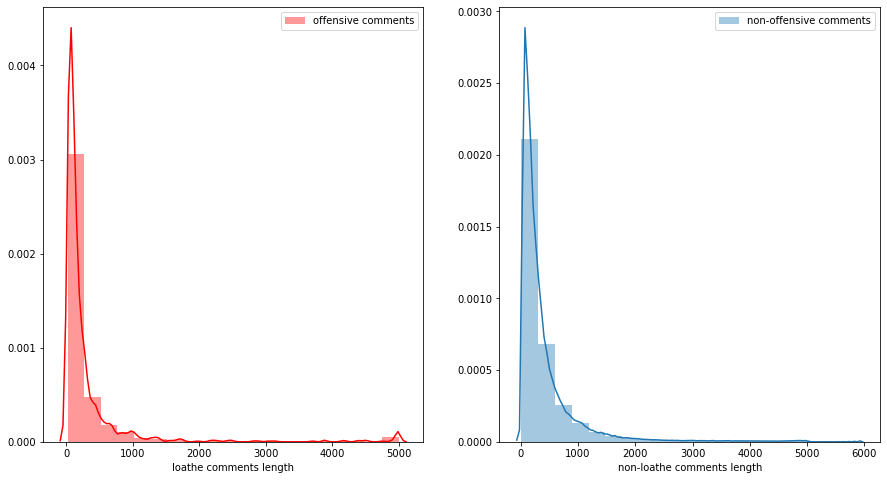

In [27]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['loathe']==1]['length_comment'],bins=20,ax=ax[0],label='offensive comments',color='r')

ax[0].set_xlabel('loathe comments length')
ax[0].legend()

sns.distplot(df_train[df_train['abuse']==0]['length_comment'],bins=20,ax=ax[1],label='non-offensive comments')
ax[1].set_xlabel('non-loathe comments length')
ax[1].legend()

plt.show()

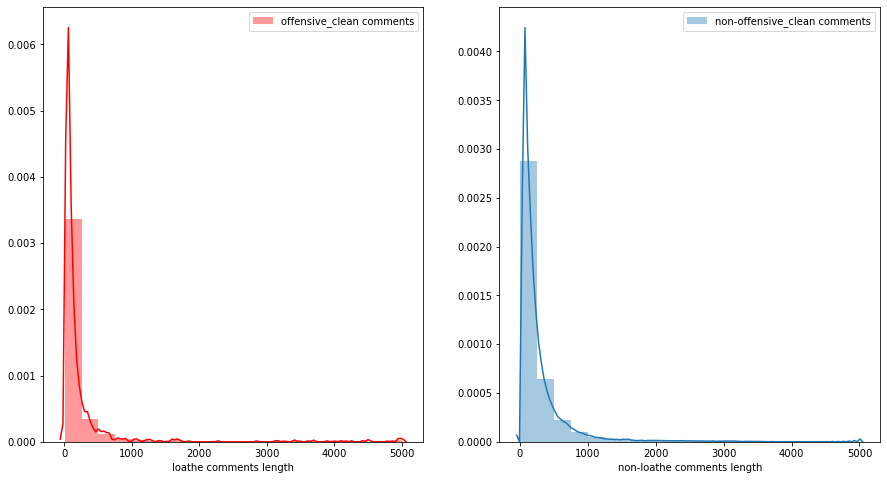

In [28]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['loathe']==1]['clean_length_of_comment_text'],bins=20,ax=ax[0],label='offensive_clean comments',color='r')

ax[0].set_xlabel('loathe comments length')
ax[0].legend()

sns.distplot(df_train[df_train['loathe']==0]['clean_length_of_comment_text'],bins=20,ax=ax[1],label='non-offensive_clean comments')
ax[1].set_xlabel('non-loathe comments length')
ax[1].legend()

plt.show()

# offensive words which are used as per different categorization

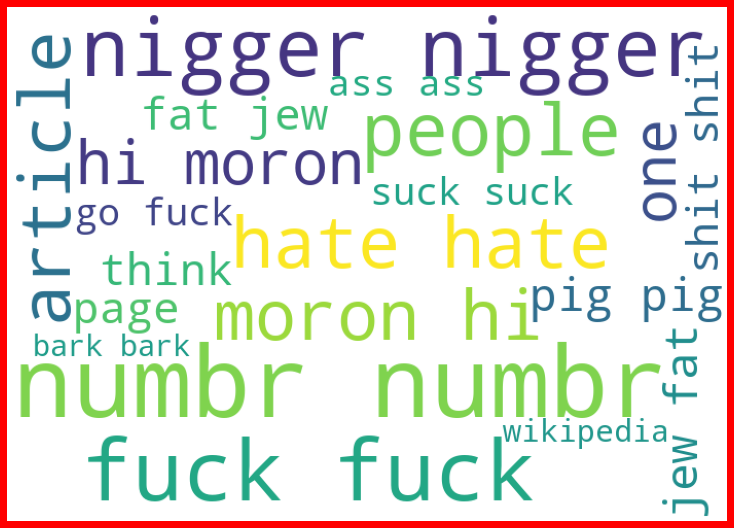

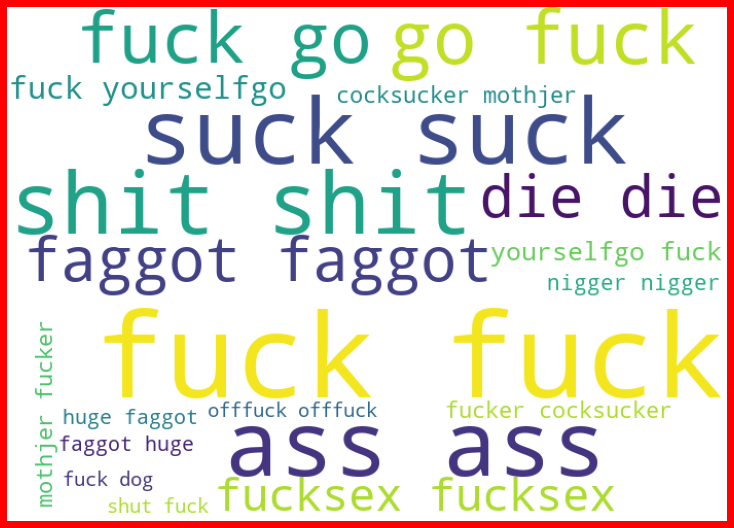

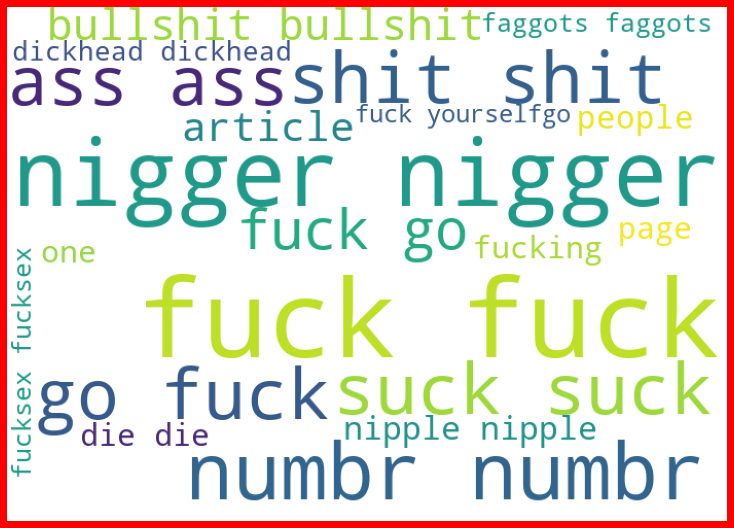

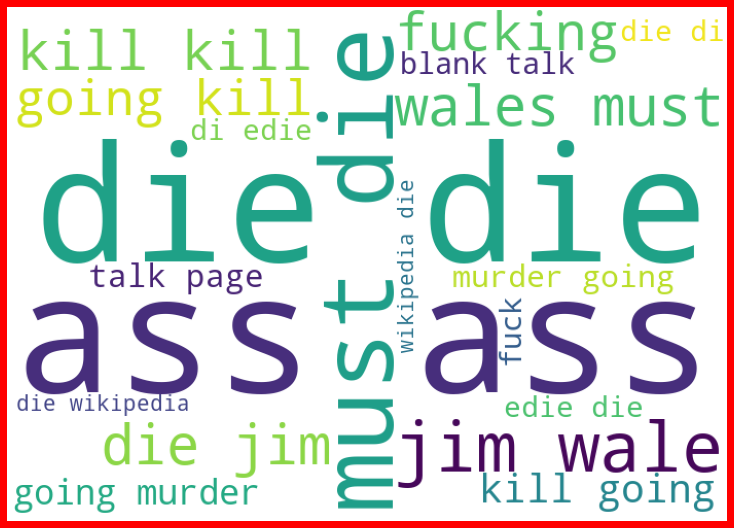

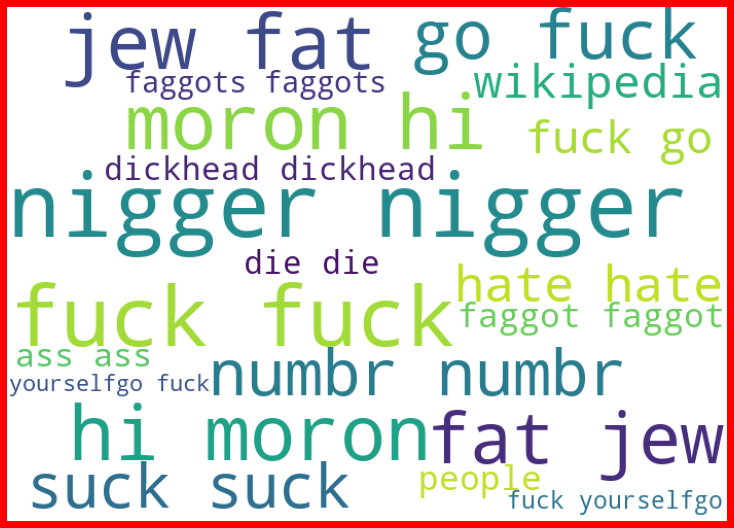

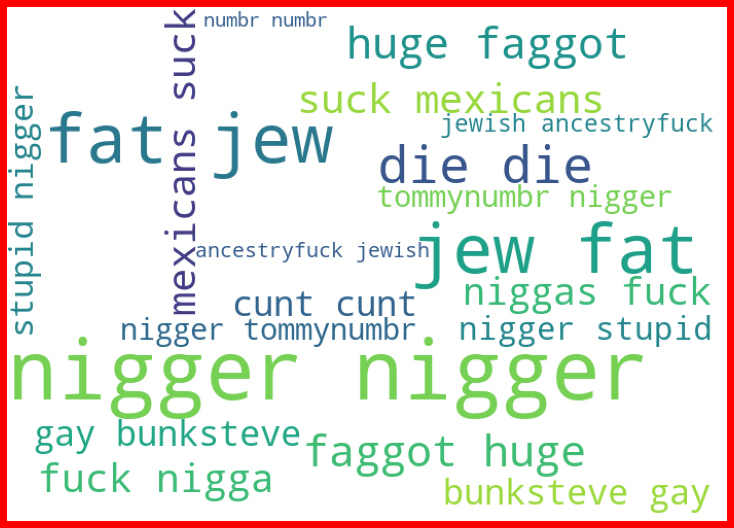

In [29]:
malignant = df_train['comment_text'][df_train['malignant']==1]

mali_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(malignant))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(mali_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

high_mali = df_train['comment_text'][df_train['highly_malignant']==1]

high_mali_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(high_mali))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(high_mali_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

rude = df_train['comment_text'][df_train['rude']==1]

rude_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(rude))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(rude_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

threat = df_train['comment_text'][df_train['threat']==1]

threat_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(threat))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(threat_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

abuse = df_train['comment_text'][df_train['abuse']==1]

abuse_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(abuse))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(abuse_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

loathe = df_train['comment_text'][df_train['loathe']==1]

loathe_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(loathe))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(loathe_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

# non-offensive words which are used as per different categorization

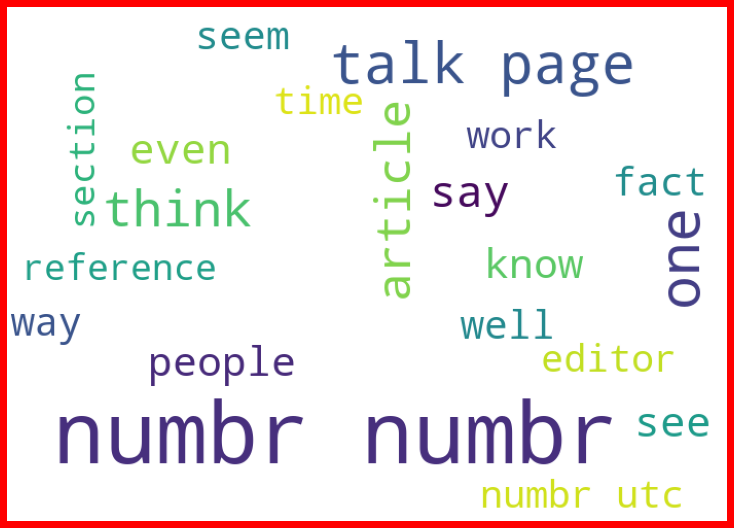

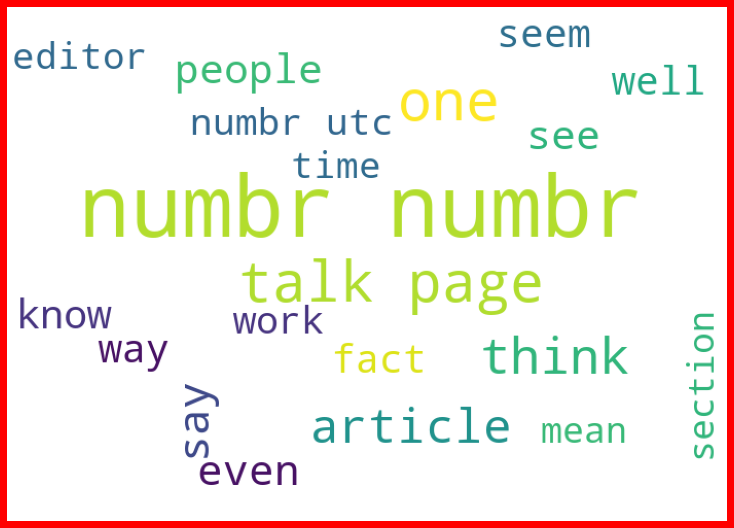

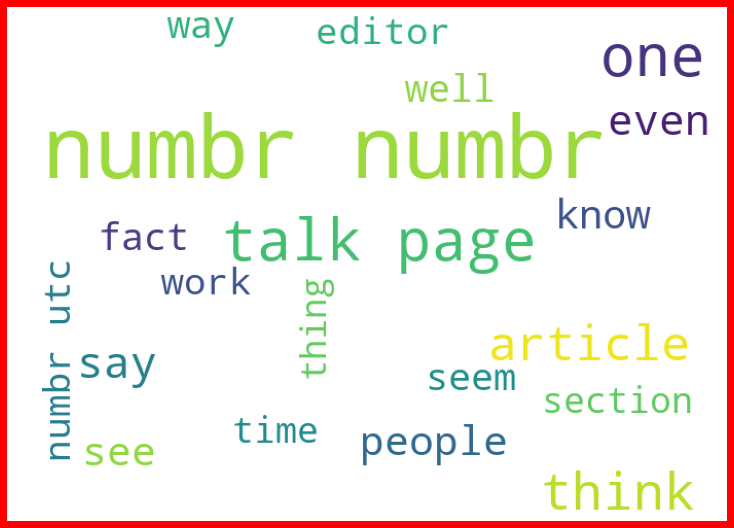

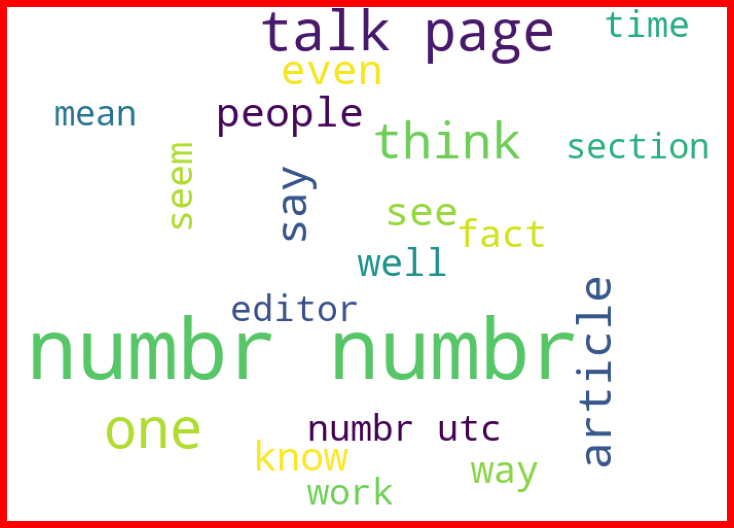

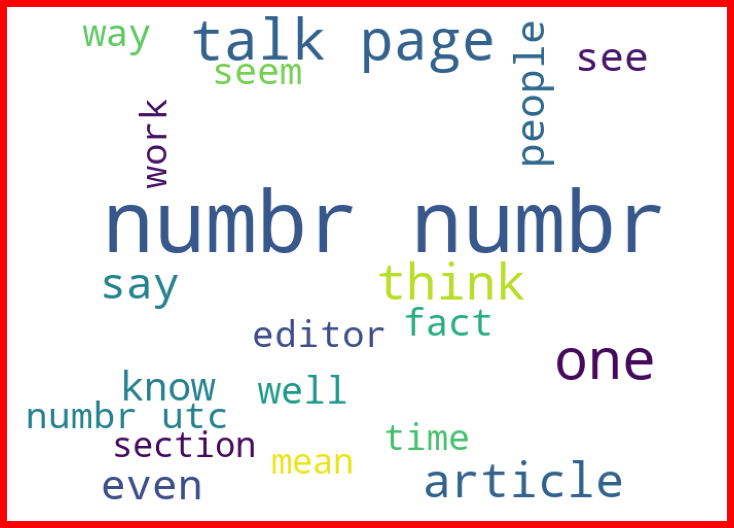

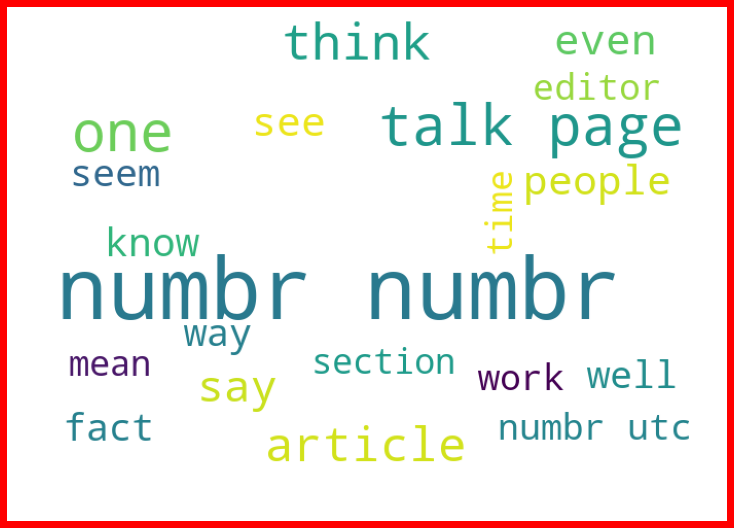

In [30]:
malignant = df_train['comment_text'][df_train['malignant']==0]

mali_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(malignant))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(mali_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

high_mali = df_train['comment_text'][df_train['highly_malignant']==0]

high_mali_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(high_mali))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(high_mali_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

rude = df_train['comment_text'][df_train['rude']==0]

rude_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(rude))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(rude_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

threat = df_train['comment_text'][df_train['threat']==0]

threat_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(threat))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(threat_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

abuse = df_train['comment_text'][df_train['abuse']==0]

abuse_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(abuse))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(abuse_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

loathe = df_train['comment_text'][df_train['loathe']==0]

loathe_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(loathe))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(loathe_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

# building a model

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve,roc_auc_score,auc
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier

vectorizer= TfidfVectorizer()
lg=LogisticRegression()
svc=SVC()
dtc=DecisionTreeClassifier()
knn=KNeighborsClassifier()
naive = MultinomialNB()

feature = vectorizer.fit_transform(df_train['comment_text'])

x = feature

In [32]:
x

<159571x181419 sparse matrix of type '<class 'numpy.float64'>'
	with 4401227 stored elements in Compressed Sparse Row format>

In [33]:
df_train.columns

Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe', 'length_comment', 'clean_length_of_comment_text'],
      dtype='object')

In [34]:
df_train['label']=df_train['malignant'].astype(int)+df_train['highly_malignant'].astype(int)+df_train['rude'].astype(int)+df_train['threat'].astype(int)+df_train['abuse'].astype(int)+df_train['loathe'].astype(int)

In [35]:
df_train.drop(columns=['malignant','highly_malignant','rude','threat','abuse','loathe'],inplace=True)

In [36]:
df_train.head()

,id,comment_text,length_comment,clean_length_of_comment_text,label
0,0000997932d777bf,explanation edits made username hardcore metal...,264,170,0
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,112,93,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,233,141,0
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,622,374,0
4,0001d958c54c6e35,sir hero chance remember page,67,29,0


In [37]:
print(df_train['label'].value_counts())

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: label, dtype: int64


0 value is consider to be non offensive comment and other values are consider to be in offensive comments

In [38]:
df_train['label']=df_train['label'].replace([1,2,3,4,5,6],1)

In [39]:
df_train['label'].value_counts()

0    143346
1     16225
Name: label, dtype: int64

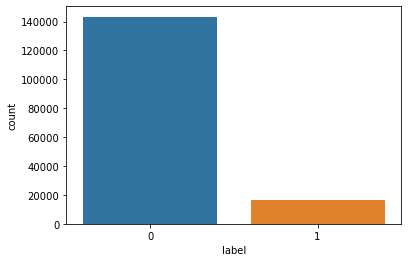

In [40]:
sns.countplot(df_train['label'])

# 0 indicates the non-offensive words while 1 indicates the offensive comments.

In [41]:
y=df_train['label']

Final score = >  0.9177299275562129
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     35834
           1       0.99      0.19      0.32      4059

    accuracy                           0.92     39893
   macro avg       0.95      0.60      0.64     39893
weighted avg       0.92      0.92      0.89     39893

[[35823    11]
 [ 3271   788]]


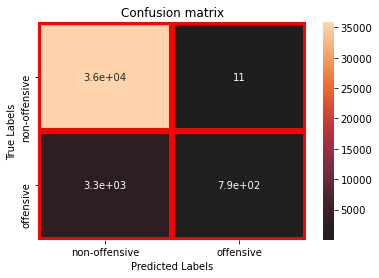

In [44]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)

naive.fit(x_train,y_train)

y_pred= naive.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['non-offensive','offensive'])
ax.yaxis.set_ticklabels(['non-offensive','offensive'])
print(conf_mat)
plt.show()

Final score = >  0.9542024916652044
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     35834
           1       0.94      0.59      0.72      4059

    accuracy                           0.95     39893
   macro avg       0.95      0.79      0.85     39893
weighted avg       0.95      0.95      0.95     39893

[[35682   152]
 [ 1675  2384]]


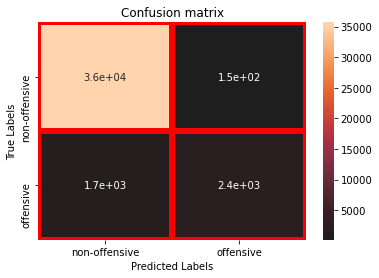

In [45]:
lg.fit(x_train,y_train)

y_pred= lg.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['non-offensive','offensive'])
ax.yaxis.set_ticklabels(['non-offensive','offensive'])
print(conf_mat)
plt.show()

Final score = >  0.8897550948788008
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     35834
           1       0.40      0.17      0.24      4059

    accuracy                           0.89     39893
   macro avg       0.66      0.57      0.59     39893
weighted avg       0.86      0.89      0.87     39893

[[34792  1042]
 [ 3356   703]]


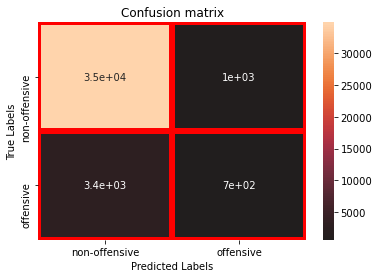

In [46]:
knn.fit(x_train,y_train)

y_pred= knn.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['non-offensive','offensive'])
ax.yaxis.set_ticklabels(['non-offensive','offensive'])
print(conf_mat)
plt.show()

Final score = >  0.9443511392976212
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     35834
           1       0.73      0.71      0.72      4059

    accuracy                           0.94     39893
   macro avg       0.85      0.84      0.85     39893
weighted avg       0.94      0.94      0.94     39893

[[34781  1053]
 [ 1167  2892]]


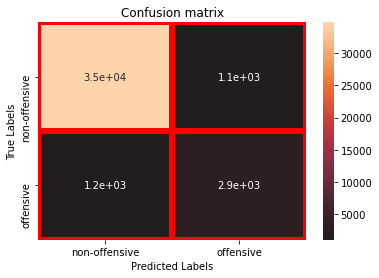

In [47]:
dtc.fit(x_train,y_train)

y_pred= dtc.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['non-offensive','offensive'])
ax.yaxis.set_ticklabels(['non-offensive','offensive'])
print(conf_mat)
plt.show()

In [48]:
GBC=GradientBoostingClassifier(criterion='friedman_mse',random_state=42,learning_rate=0.1,n_estimators=100,max_depth=4)
BC=BaggingClassifier(n_estimators=100)

Final score = >  0.9428220489810243
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     35834
           1       0.95      0.46      0.62      4059

    accuracy                           0.94     39893
   macro avg       0.95      0.73      0.80     39893
weighted avg       0.94      0.94      0.93     39893

[[35734   100]
 [ 2181  1878]]


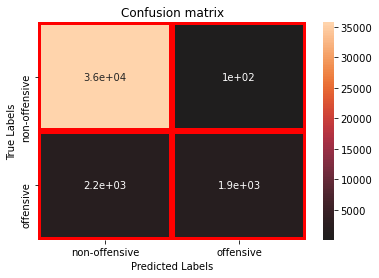

In [49]:
GBC.fit(x_train,y_train)

y_pred= GBC.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['non-offensive','offensive'])
ax.yaxis.set_ticklabels(['non-offensive','offensive'])
print(conf_mat)
plt.show()

# as i can see only logistic regression is getting the highest accuracy i choose to opt this model for my project.